<a href="https://colab.research.google.com/github/mamuncseru/deep_understanding_deep_learning/blob/main/DUDL_CNN_CodeChallenge_GaussAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# summary info on models
from torchsummary import summary

In [3]:
# use GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Create Gaussian blurs with different widths

In [4]:
nGauss = 1000
imgSize = 91

x = np.linspace(-4, 4, imgSize)
X, Y = np.meshgrid(x, x)

# the two widths (a.u.)
widths = np.linspace(2, 20, nGauss)

# initialize tensors containing images and labels
images = torch.zeros(nGauss, 1, imgSize, imgSize)

# images without oclusion
fresh_images = torch.zeros(nGauss, 1, imgSize, imgSize)

for i in range(nGauss):

    # create the gaussian with random centers
    ro = 2*np.random.randn(2) # ro = random offset
    G = np.exp(-( (X-ro[0])**2 + (Y-ro[1])**2) / (2*widths[i%2]**2) )

    # and add noise
    G = G + np.random.randn(imgSize, imgSize) / 5
    
    # images without ocluded
    fresh_images[i, :, :, :] = torch.Tensor(G).view(1, imgSize, imgSize)

    # add a random bar randomly
    i1 = np.random.choice(np.arange(2, 28))
    i2 = np.random.choice(np.arange(2, 6))
    if np.random.randn() > 0:
        G[i1:i1+i2, ] = 1
    else:
        G[:, i1:i1+i2] = 1

    # add to the tensor
    images[i, :, :, :] = torch.Tensor(G).view(1, imgSize, imgSize)

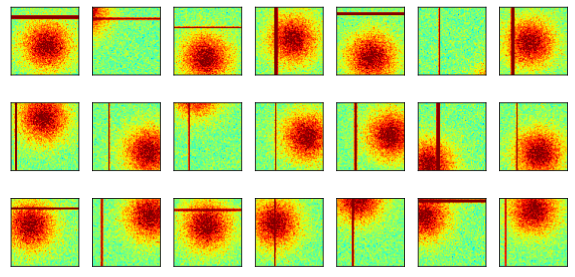

In [7]:
# visualize some images

fig, axs = plt.subplots(3, 7, figsize=(10, 5))
imgIdx = []
for i, ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(nGauss)
    imgIdx.append(whichpic)
    G = np.squeeze(images[whichpic, :, :])
    ax.imshow(G, vmin=-1, vmax=1, cmap='jet')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

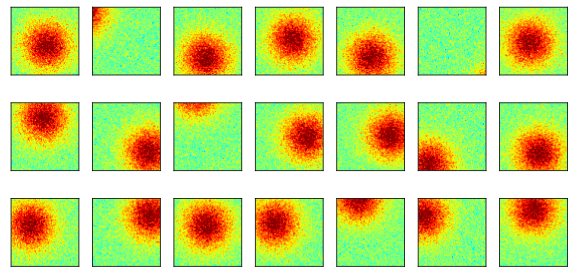

In [8]:
# visualize same images but without oclusion

fig, axs = plt.subplots(3, 7, figsize=(10, 5))

for i, ax in enumerate(axs.flatten()):
    G = np.squeeze(fresh_images[imgIdx[i], :, :])
    ax.imshow(G, vmin=-1, vmax=1, cmap='jet')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

## Create the DL model

In [ ]:
#  # create a class for the model
# def makeTheNet():

#     class gausnet(nn.Module):
#         def __init__(self):
#             super().__init__()

#             # all layers in one go using nn.Sequential

#             self.enc = nn.Sequential(
#                 nn.Conv2d(1, 6, 3, padding=1),     # output size = (91 + 2 *1 - 3)/1 + 1 = 91
#                 nn.ReLU(),                         # note that relu is treated like a "layer"
#                 nn.MaxPool2d(2, 2),                # output size: 91/2 = 45
#                 nn.Conv2d(6, 4, 3, padding=1),     # output size = (45 + 2*1 - 3)/1 + 1 = 45
#                 nn.ReLU(),                         # 
#                 nn.MaxPool2d(2, 2),                # output size = 45/2 = 22
#             )

#             self.dec = nn.Sequential(
#                 nn.ConvTranspose2d(4, 6, 3, 2),
#                 nn.ReLU(),
#                 nn.ConvTranspose2d(6, 1, 3, 2)
#             )

#         def forward(self, x):
#             return self.dec(self.enc(x))

    
#     # create the model instance
#     net = gausnet()

#     # loss function
#     lossfun = nn.BCEWithLogitsLoss()

#     # optimzier
#     optimizer = torch.optim.Adam(net.parameters(), lr=.001)

#     return net, lossfun, optimizer



In [9]:
 # create a class for the model
def makeTheNet():

    class gausnet(nn.Module):
        def __init__(self):
            super().__init__()

            # encoding
            self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
            self.conv2 = nn.Conv2d(6, 4, 3, padding=1)

            # decoding

            self.transconv1 = nn.ConvTranspose2d(4, 6, 3, 2)
            self.transconv2 = nn.ConvTranspose2d(6, 1, 3, 2)

        def forward(self, x):
            conv1act = F.relu(self.conv1(x))
            x = F.max_pool2d(conv1act, (2,2))
            conv2act = F.relu(self.conv2(x))
            x = F.max_pool2d(conv2act, (2,2))
            x = F.relu(self.transconv1(x))
            x = self.transconv2(x)
            return x, conv1act, conv2act

    
    # create the model instance
    net = gausnet()

    # loss function
    lossfun = nn.BCEWithLogitsLoss()

    # optimzier
    optimizer = torch.optim.Adam(net.parameters(), lr=.001)

    return net, lossfun, optimizer



 
torch.Size([10, 1, 91, 91])


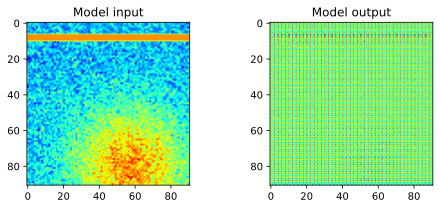

In [10]:
# test the model with one batch
net, lossfun, optimzier = makeTheNet()

yHat, conv1act, conv2act = net(images[:10, :, :, :])

# check size of output
print(' ')
print(yHat.shape)

# now let's compute the loss
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].imshow(torch.squeeze(images[0, 0, :, :]).detach(), cmap='jet')
ax[0].set_title('Model input')
ax[1].imshow(torch.squeeze(yHat[0, 0, :, :]).detach(), cmap='jet')
ax[1].set_title('Model output')

plt.show()

In [11]:
# count the total number of parametes in the model
summary(net.to(device), (1, imgSize, imgSize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
            Conv2d-2            [-1, 4, 45, 45]             220
   ConvTranspose2d-3            [-1, 6, 45, 45]             222
   ConvTranspose2d-4            [-1, 1, 91, 91]              55
Total params: 557
Trainable params: 557
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.60
Params size (MB): 0.00
Estimated Total Size (MB): 0.63
----------------------------------------------------------------


## Create a function that trains the model

In [12]:
# a function that trains the model

def function2trainTheModel():

    # number of epochs
    numepochs = 1000

    # create a new model
    net, lossfun, optimizer = makeTheNet()
    net.to(device)

    # intialize losses
    losses = torch.zeros(numepochs)


    # loop over epochs
    for epochi in range(numepochs):

        pics2use = np.random.choice(nGauss, size=32, replace=False)
        X = images[pics2use, :, :, :]
        y = fresh_images[pics2use, :, :, :]
        X = X.to(device)
        y = y.to(device)


        # forward pass and loss
        yHat = net(X)[0]
        loss = lossfun(yHat, y)
        losses[epochi] = loss.item()
        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # end of loop

    # function output
    return losses, net

In [ ]:
## Run the model and show the results!

In [13]:
losses, net = function2trainTheModel()


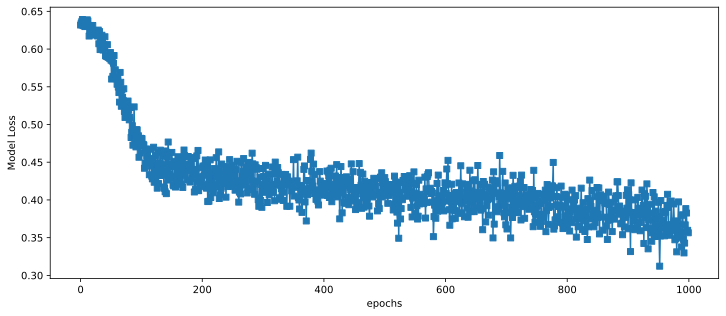

In [14]:
fig, ax = plt.subplots(1, figsize=(12, 5))

ax.plot( losses, 's-')
ax.set_xlabel('epochs')
ax.set_ylabel('Model Loss')


plt.show()

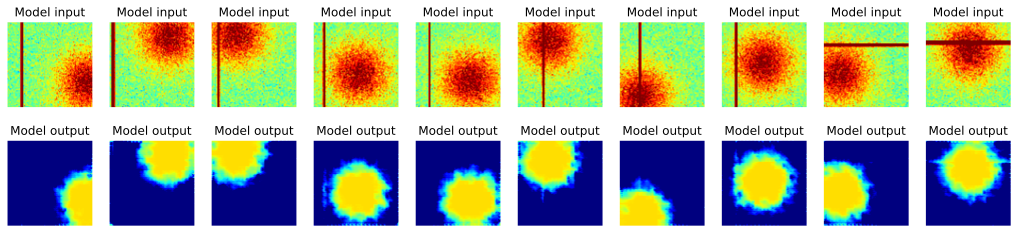

In [15]:
# visualize some images
pics2use = np.random.choice(nGauss, size=32, replace=False)
X = images[pics2use, :, :, :]
yHat, featmap1, featmap2 = net(X)

fig, axs = plt.subplots(2, 10, figsize=(18, 4))

for i in range(10):

    G = torch.squeeze(X[i, 0, :, :]).detach()
    O = torch.squeeze(yHat[i, 0, :, :]).detach()


    axs[0, i].imshow(G, vmin=-1, vmax=1, cmap='jet')
    axs[0, i].axis('off')
    axs[0, i].set_title('Model input')

    axs[1, i].imshow(O, vmin=-1, vmax=1, cmap='jet')
    axs[1, i].axis('off')
    axs[1, i].set_title('Model output')

plt.show()

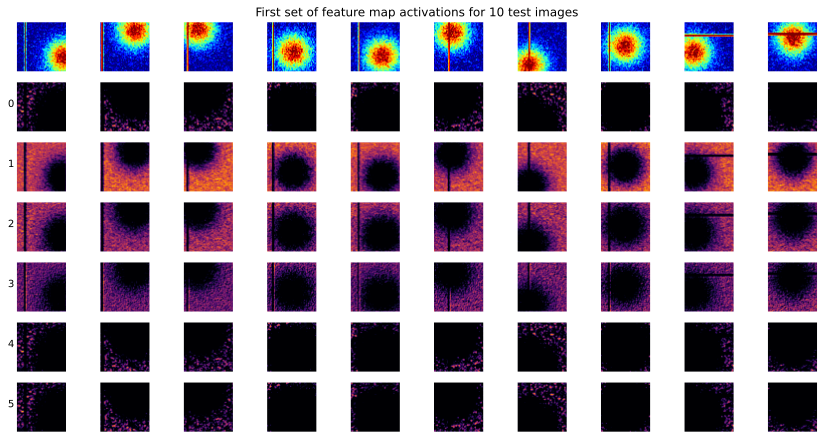

In [16]:
# feature maps from the conv1 layer

fig, axs = plt.subplots(7, 10, figsize=(12, 6))

for pici in range(10):

    # show the original picture
    img = X[pici, 0, :, :].detach()
    axs[0, pici].imshow(img, cmap='jet', vmin=0, vmax=1)
    axs[0, pici].axis('off')


    for feati in range(6):
        # extract the feature map from this image
        img = featmap1[pici, feati, :, :].detach()
        axs[feati+1, pici].imshow(img, cmap='inferno', vmin=0, vmax=torch.max(img)*.9)
        axs[feati+1, pici].axis('off')
        axs[feati+1, pici].text(-5, 45, feati, ha='right') if pici==0 else None

plt.tight_layout()
plt.suptitle('First set of feature map activations for 10 test images', x=.5, y=1.01)
plt.show()

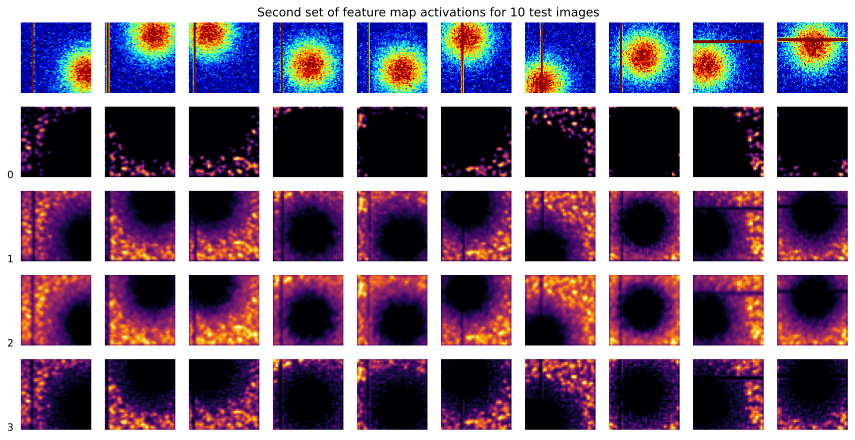

In [17]:
# feature maps from the conv1 layer

fig, axs = plt.subplots(5, 10, figsize=(12, 6))

for pici in range(10):

    # show the original picture
    img = X[pici, 0, :, :].detach()
    axs[0, pici].imshow(img, cmap='jet', vmin=0, vmax=1)
    axs[0, pici].axis('off')
    # axs[0, pici].text(2,2, 'T:%s'%int(y[pici].item()), ha='left', va='top', color='w', fontweight=3)

    for feati in range(4):
        # extract the feature map from this image
        img = featmap2[pici, feati, :, :].detach()
        axs[feati+1, pici].imshow(img, cmap='inferno', vmin=0, vmax=torch.max(img)*.9)
        axs[feati+1, pici].axis('off')
        axs[feati+1, pici].text(-5, 45, feati, ha='right') if pici==0 else None

plt.tight_layout()
plt.suptitle('Second set of feature map activations for 10 test images', x=.5, y=1.01)
plt.show()